In [ ]:
path = './Images/'
annot = './Airplanes_Annotations/'

In [ ]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
!unzip Images

In [ ]:
!unzip Airplanes_Annotations

In [ ]:
cv2.setUseOptimized(True)
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

airplane_109.jpg


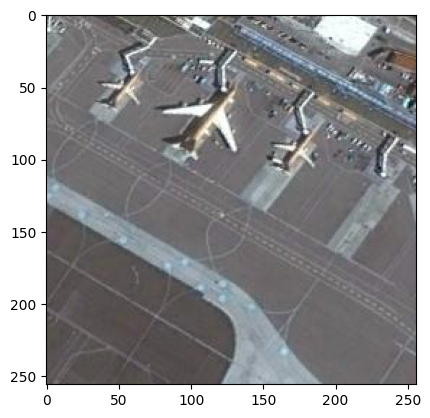

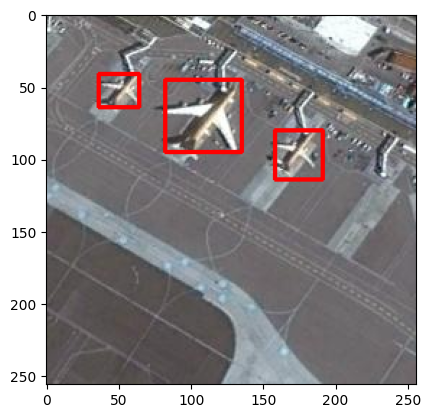

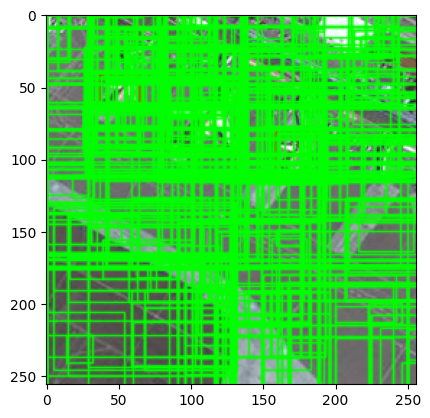

In [ ]:
for e, i in enumerate(os.listdir(annot)):
    if e < 10:
        filename = i.split(".")[0]+".jpg"
        print(filename)
        img = cv2.imread(os.path.join(path, filename))
        df = pd.read_csv(os.path.join(annot, i))
        plt.imshow(img)
        for row in df.iterrows():
            x1 = int(row[1][0].split(" ")[0])
            y1 = int(row[1][0].split(" ")[1])
            x2 = int(row[1][0].split(" ")[2])
            y2 = int(row[1][0].split(" ")[3])
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        plt.figure()
        plt.imshow(img)
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        imgOut = img.copy()
        for i, rect in enumerate(rects):
            x, y, w, h = rect
            cv2.rectangle(imgOut, (x, y), (x+w, y+h),
                          (0, 255, 0), 1, cv2.LINE_AA)
        plt.figure()
        plt.imshow(imgOut)
        break


In [ ]:
def get_iou(bb1, bb2):
  assert bb1['x1'] < bb1['x2']
  assert bb1['y1'] < bb1['y2']
  assert bb2['x1'] < bb2['x2']
  assert bb2['y1'] < bb2['y2']

  x_left = max(bb1['x1'], bb2['x1'])
  y_top = max(bb1['y1'], bb2['y1'])
  x_right = min(bb1['x2'], bb2['x2'])
  y_bottom = min(bb1['y2'], bb2['y2'])

  if x_right < x_left or y_bottom < y_top:
    return 0.0

  intersection_area = (x_right - x_left) * (y_bottom - y_top)

  bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
  bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

  iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
  assert iou >= 0.0
  assert iou <= 1.0
  return iou

In [ ]:
train_images = []
train_labels = []

In [ ]:
for e, i in enumerate(os.listdir(annot)):
    try:
        if i.startswith('airplane'):
            filename = i.split(".")[0]+".jpg"
            img = cv2.imread(os.path.join(path, filename))
            df = pd.read_csv(os.path.join(annot, i))
            getvalues = []
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                getvalues.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})
            ss.setBaseImage(img)
            ss.switchToSelectiveSearchFast()
            rects = ss.process()
            imgout = img.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            fflag = 0
            bflag = 0
            for idx, result in enumerate(rects):
                if idx < 2000 and flag == 0:
                    for val in getvalues:
                        x, y, w, h = result
                        iou = get_iou(
                            val, {"x1": x, "y1": y, "x2": x+w, "y2": y+h})
                        if counter < 30:
                            if iou > 0.70:
                                timage = imgout[x:x+w,y:y+h]
                                resized = cv2.resize(
                                    timage, (224, 224), interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else:
                            fflag = 1
                        if falsecounter < 30:
                            if iou < 0.30:
                                timage = imgout[x:x+w,y:y+h]
                                resized=cv2.resize(timage,(224,224),interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter+=1
                        else:
                             bflag=1
                    if fflag==1 and bflag==1:
                        flag=1

    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
X_new=np.array(train_images)
Y_new=np.array(train_labels)

In [ ]:
X_new.shape,Y_new.shape

((8860, 224, 224, 3), (8860,))

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

In [ ]:
vgg16=VGG16(weights='imagenet',include_top=True)
vgg16.summary()

553467096/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
for layers in vgg16.layers[:-2]:
    layers.trainable=False
x=vgg16.get_layer('fc2')
last_output=x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)  
model = tf.keras.Model(vgg16.input,x)
model.compile(optimizer = "adam", 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.fit(X_new,Y_new,batch_size = 32,epochs = 3, verbose = 1,validation_split=0.05,shuffle = True)

Epoch 1/3
264/264 [==============================] - 51s 141ms/step - loss: 0.8664 - acc: 0.8071 - val_loss: 0.5577 - val_acc: 0.7472
Epoch 2/3
264/264 [==============================] - 35s 131ms/step - loss: 0.3015 - acc: 0.8747 - val_loss: 0.8273 - val_acc: 0.7404
Epoch 3/3
264/264 [==============================] - 35s 133ms/step - loss: 0.2466 - acc: 0.8976 - val_loss: 0.8055 - val_acc: 0.7381


In [ ]:
svm_image = [];
svm_label = [];

In [ ]:
for e,i in enumerate(os.listdir(annot)):
    try:
        if i.startswith("airplane"):
            filename = i.split(".")[0]+".jpg"
            image = cv2.imread(os.path.join(path,filename))
            df = pd.read_csv(os.path.join(annot,i))
            gtvalues=[]
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3]) 
                gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
                timage = image[x1:x2,y1:y2]
                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                svm_image.append(resized)
                svm_label.append([0,1])
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            imout = image.copy()
            counter = 0
            falsecounter = 0
            flag = 0
            for e,result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        x,y,w,h = result
                        iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                        if falsecounter <5:
                            if iou < 0.3:
                                timage = imout[x:x+w,y:y+h]
                                resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                                svm_image.append(resized)
                                svm_label.append([1,0])
                                falsecounter += 1
                        else :
                            flag = 1
    except Exception as e:
        print(e)
        print("error in "+filename)
        continue

In [ ]:
x =model.get_layer('fc2').output
Y = tf.keras.layers.Dense(2)(x)
final_model = tf.keras.Model(model.input,Y)
final_model.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])
final_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 10,verbose = 1,shuffle = True,validation_split = 0.05)

Epoch 1/10
47/47 [==============================] - 13s 249ms/step - loss: 0.6824 - accuracy: 0.7406 - val_loss: 0.6904 - val_accuracy: 0.6962
Epoch 2/10
47/47 [==============================] - 6s 136ms/step - loss: 0.4447 - accuracy: 0.8168 - val_loss: 0.7742 - val_accuracy: 0.7215
Epoch 3/10
47/47 [==============================] - 6s 129ms/step - loss: 0.3607 - accuracy: 0.8463 - val_loss: 0.7780 - val_accuracy: 0.7089
Epoch 4/10
47/47 [==============================] - 6s 138ms/step - loss: 0.3106 - accuracy: 0.8670 - val_loss: 0.8399 - val_accuracy: 0.7089
Epoch 5/10
47/47 [==============================] - 6s 130ms/step - loss: 0.3345 - accuracy: 0.8576 - val_loss: 0.9433 - val_accuracy: 0.6962
Epoch 6/10
47/47 [==============================] - 7s 139ms/step - loss: 0.2585 - accuracy: 0.8944 - val_loss: 0.9852 - val_accuracy: 0.6582
Epoch 7/10
47/47 [==============================] - 6s 131ms/step - loss: 0.2456 - accuracy: 0.9071 - val_loss: 1.1030 - val_accuracy: 0.6329
Epoch

1/1 [==============================] - 0s 20ms/step


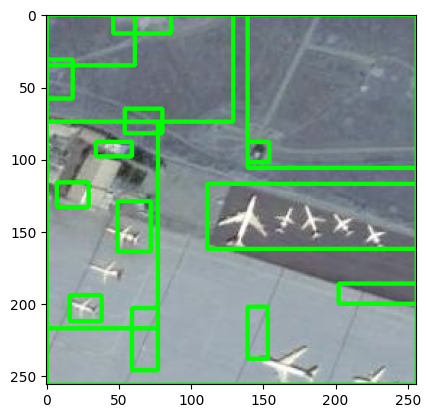

In [ ]:
image = cv2.imread(os.path.join(path,'airplane_020.jpg'))
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

imOut = image.copy()
boxes = []
scores=[]
count = 0
for e,result in enumerate(ssresults):
  if e < 2000:
    x,y,w,h = result
    timage = imout[x:x+w,y:y+h]
    resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
    resized = np.expand_dims(resized,axis = 0)
    out = final_model.predict(resized)
    if(out[0][0] > 0.95):
      boxes.append([x,y,x+w,y+h])
      scores.append(out[0][0])

indices=cv2.dnn.NMSBoxes(boxes,scores,score_threshold=0.2, nms_threshold=0.25)
for i in indices:
    # i = i[0]
    x, y, x2, y2 = boxes[i]
    cv2.rectangle(imOut, (x, y), (x2, y2), (0, 255, 0), 2)

plt.imshow(imOut)

In [ ]:
final_model.save('model1.h5')